# Zomato Data – EDA & Demand Forecasting
⚠️ Note: Dataset does not contain a date column. For demonstration, row index is treated as time and `votes` is treated as demand.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [2]:

df = pd.read_csv("/content/Zomato-data.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.head()


,name,online_order,book_table,rate,votes,approx_cost(for_two_people),listed_in(type)
0,Jalsa,Yes,Yes,4.1/5,775,800,Buffet
1,Spice Elephant,Yes,No,4.1/5,787,800,Buffet
2,San Churro Cafe,Yes,No,3.8/5,918,800,Buffet
3,Addhuri Udupi Bhojana,No,No,3.7/5,88,300,Buffet
4,Grand Village,No,No,3.8/5,166,600,Buffet


## Exploratory Data Analysis

In [3]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   name                         148 non-null    object
 1   online_order                 148 non-null    object
 2   book_table                   148 non-null    object
 3   rate                         148 non-null    object
 4   votes                        148 non-null    int64 
 5   approx_cost(for_two_people)  148 non-null    int64 
 6   listed_in(type)              148 non-null    object
dtypes: int64(2), object(5)
memory usage: 8.2+ KB


,votes,approx_cost(for_two_people)
count,148.000000,148.000000
mean,264.810811,418.243243
std,653.676951,223.085098
min,0.000000,100.000000
25%,6.750000,200.000000
50%,43.500000,400.000000
75%,221.750000,600.000000
max,4884.000000,950.000000


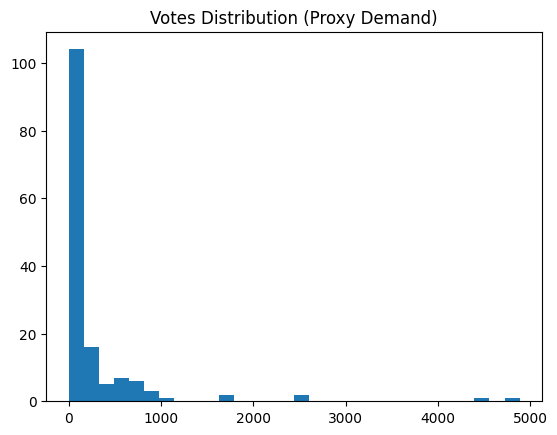

In [4]:

plt.figure()
plt.hist(df['votes'], bins=30)
plt.title("Votes Distribution (Proxy Demand)")
plt.show()


## Time Series Preparation

In [5]:

# Treat index as time
ts = df['votes'].fillna(df['votes'].median()).values.reshape(-1,1)

scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts)


In [6]:

def create_sequences(data, seq_len=10):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(ts_scaled)


## LSTM Demand Forecasting

In [7]:

model = Sequential([
    LSTM(50, activation='relu', input_shape=(X.shape[1], 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=10, batch_size=16)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0232
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0137 
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0201 
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0108 
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0072 
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0082
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


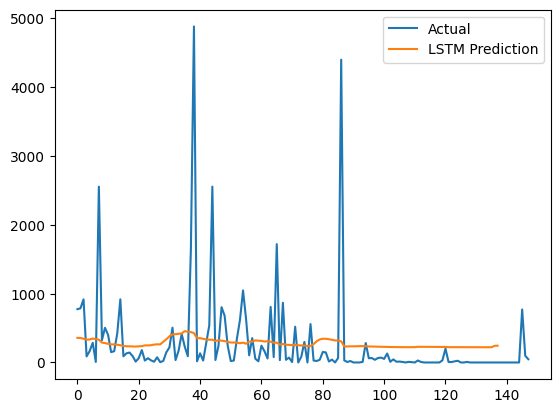

In [8]:

predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

plt.figure()
plt.plot(ts, label='Actual')
plt.plot(predictions, label='LSTM Prediction')
plt.legend()
plt.show()
